In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import ast

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,Unnamed: 0,Report Info,Section,Data Description,Data Value,Uncertainty on the data (%),Unit,EmissionFactor,Amortization - NBR year,Acquisition Year
0,159,"{'name': 'Tapio', 'location': 'Bruxelles', 'da...",Mobility,Car - team building,4103.180371,0.2,vehicle.km,Car - France - 0.384 - vehicle.km - 0.6,NaN,NaN
1,18,"{'name': 'Tapio', 'location': 'Bruxelles', 'da...",Products & Services,Cardboard,132.394960,0.2,ton,Textbooks - France - 40.0 - ton - 0.5,NaN,NaN
2,52,"{'name': 'Tapio', 'location': 'Bruxelles', 'da...",Waste Consumption,Average household waste,73.288790,0.2,ton,Residual Waste - France - 362.0 - ton - 0.87,NaN,NaN
3,64,"{'name': 'Tapio', 'location': 'Bruxelles', 'da...",Products & Services,Daily internet consumption,163.111265,0.1,FTE,Digital consumption - France - 49.2 - FTE - 1.0,NaN,NaN
4,9,"{'name': 'Tapio', 'location': 'Paris', 'date':...",Energy Consumption,Grey electricity - Homeworking,1890.280000,0.5,kWh,Grey Electricity - France - 0.205 - kWh - 0.15,NaN,NaN


Extraction de la date d'aprés la clonne "Report Info"

In [4]:
def extract_date(report_info):
    try:

        report_dict = ast.literal_eval(report_info)
        return report_dict.get("date")
    except (ValueError, SyntaxError):
        return None

data['date'] = data['Report Info'].apply(extract_date)
data['date'] = pd.to_datetime(data['date'], format='%Y', errors='coerce')

Supprimer les duplications

In [5]:
data.drop_duplicates(inplace=True)

La gestion des valeurs manquantes

In [6]:
for col in ['Data Value', 'Uncertainty on the data (%)', 'EmissionFactor', 'Acquisition Year']:
    data[col] = pd.to_numeric(data[col], errors='coerce')
data.fillna({'Data Value': data['Data Value'].median(),
             'Uncertainty on the data (%)': data['Uncertainty on the data (%)'].median()}, inplace=True)

In [7]:
data['Unit'] = data['Unit'].str.lower()
data['Section'] = data['Section'].str.title()

**Connexion SQlite**

In [8]:
conn = sqlite3.connect('emissions.db')
cursor = conn.cursor()

In [9]:
data.to_sql('emissions', conn, if_exists='replace', index=False)

187

Creation de la table

In [13]:
table_creation_query = '''
CREATE TABLE IF NOT EXISTS emissions (
    report_name TEXT,
    location TEXT,
    date DATE,
    section TEXT,
    data_description TEXT,
    data_value REAL,
    uncertainty REAL,
    unit TEXT,
    emission_factor REAL,
    amortization TEXT,
    acquisition_year INTEGER
);
'''
cursor.execute(table_creation_query)

**Analyse des données**

Calcul des émissions annuelles pour Bruxelles

In [17]:
query = """
SELECT strftime('%Y', date) as year, SUM("Data Value") as total_emissions
FROM emissions
WHERE "Report Info" LIKE '%Bruxelles%'
GROUP BY year
ORDER BY year;
"""
annual_emissions = pd.read_sql_query(query, conn)

In [19]:
print(annual_emissions)

   year  total_emissions
0  None              inf
1  2022              inf
2  2023     8.142042e+04
3  2024              inf
4  2025     9.395501e+04


Nettoyer les données pour la visualisation et la modélisation

In [28]:
annual_emissions.dropna(subset=['year', 'total_emissions'], inplace=True)
annual_emissions['year'] = annual_emissions['year'].astype(int)
annual_emissions = annual_emissions[np.isfinite(annual_emissions['total_emissions'])]
annual_emissions = annual_emissions[annual_emissions['total_emissions'] < 1e6]

**Visualisation**

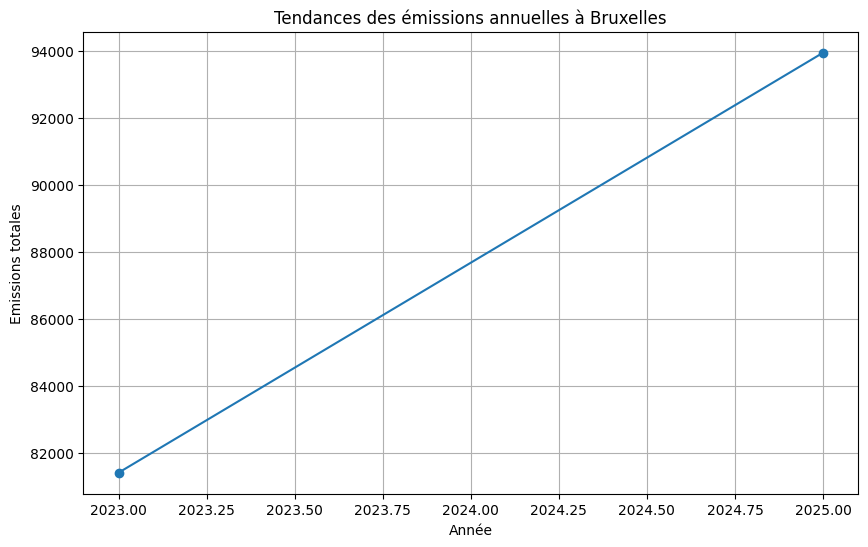

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(annual_emissions['year'], annual_emissions['total_emissions'], marker='o')
plt.title('Tendances des émissions annuelles à Bruxelles')
plt.xlabel('Année')
plt.ylabel('Emissions totales')
plt.grid(True)
plt.show()

Modélisation **prédictive**

Préparer les données pour la régression

In [30]:
X = annual_emissions['year'].astype(int).values.reshape(-1, 1)
y = annual_emissions['total_emissions'].values

In [39]:
model = LinearRegression()
model.fit(X,y)

LinearRegression()

Prévision pour 2026

In [32]:
future_year = np.array([[2026]])
future_prediction = model.predict(future_year)

Évaluation du modèle

In [33]:
y_pred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

In [34]:
print("\nPerformance du modèle :")
print(f"RMSE : {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"Prévision des émissions pour 2026 : {future_prediction[0]:.2f}")


Performance du modèle :
RMSE : 0.00
MAE : 0.00
Prévision des émissions pour 2026 : 100222.31


In [36]:
results = annual_emissions.copy()
results['prediction'] = model.predict(X)
results.to_csv('emissions_analysis.csv', index=False)

In [37]:
ideas = """
1. Utilisation de l'IA pour détecter automatiquement les anomalies dans les données d'émissions.
2. Prévision des émissions en utilisant des modèles avancés de séries temporelles.
3. Automatisation des rapports d'émissions avec visualisations adaptatives.
4. Intégration de modèles d'optimisation pour réduire les émissions.
"""
with open('ai_ideas_tapio.txt', 'w') as f:
    f.write(ideas)